In [2]:
# Setup notebook

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import utide

from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from tqdm.notebook import tqdm
sns.set()

import sys
sys.path.append("..")
from src import features, models
from src import definitions as defs

%load_ext autoreload
%autoreload 2
%matplotlib widget
%config Completer.use_jedi = False

%load_ext rpy2.ipython

wdir = defs.ROOT / "data"

In [3]:
def find_highs(data):
    search_distance = pd.Timedelta("1H") / data.index.freq * 8
    high_loc = data.iloc[find_peaks(x=data.values, distance=search_distance)[0]].index
    return data.loc[high_loc]

In [4]:
ast = pd.read_feather(wdir / "processed" / "tides.feather").set_index("datetime").squeeze()
ast.index = pd.DatetimeIndex(data=ast.index, freq="infer")

sk = pd.read_csv(wdir / "processed" / "sutarkhali_adjusted.csv").set_index("datetime").squeeze()
sk.index = pd.DatetimeIndex(data=sk.index, freq="infer")

mg = pd.read_csv(wdir / "processed" / "mongla_tides.csv").set_index("datetime").squeeze()
mg.index = pd.DatetimeIndex(data=mg.index, freq="infer")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
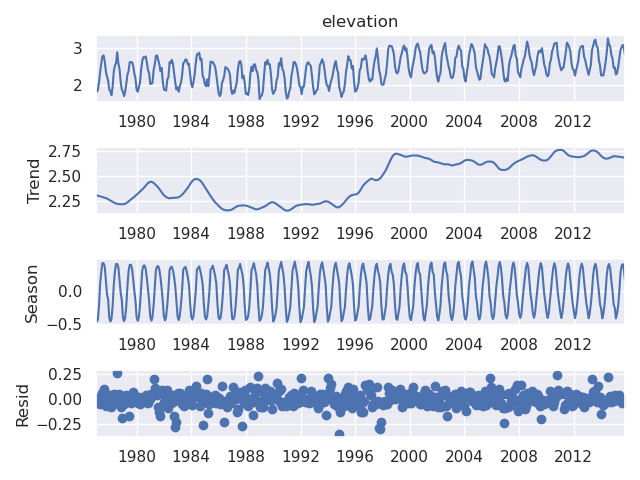

In [11]:
data = mg.to_frame()

freq = data.index[1] - data.index[0]
n_per_hour = pd.Timedelta("1 hour") / freq

data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq=freq, name="datetime"))
data.elevation = data.elevation.interpolate(method="time", limit=1, limit_direction="both")

drop = data.elevation.groupby(by=pd.Grouper(freq="MS")).agg(nulls=lambda x: x.isnull().mean())
drop = drop.loc[drop.nulls > 0.3].index

monthly = data.elevation.groupby(by=pd.Grouper(freq="MS")).median()
monthly.loc[drop] = np.nan
monthly = monthly.interpolate(method="time", limit_direction="both")
stl = STL(endog=monthly, seasonal=13, robust=True)
res = stl.fit()
data["trend"] = res.trend.reindex(index=data.index).interpolate()
data.elevation = data.elevation - data.trend
res.plot();

In [13]:
ast_highs = find_highs(ast)
sk_highs = find_highs(sk)
mg_highs = find_highs(data.elevation)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
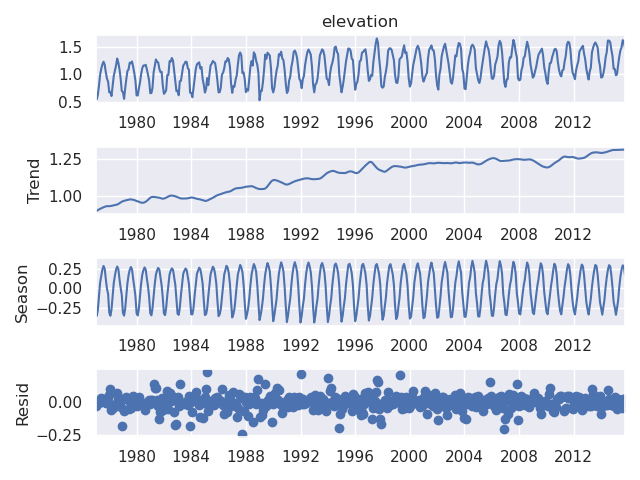

In [14]:
endog = mg_highs.groupby(pd.Grouper(freq="MS")).mean()
stl = STL(endog=endog, seasonal=13, robust=True)
res = stl.fit()
res.plot();
trend = res.trend.reindex(index=mg_highs.index).interpolate(limit_direction="both")

<AxesSubplot:xlabel='datetime'>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
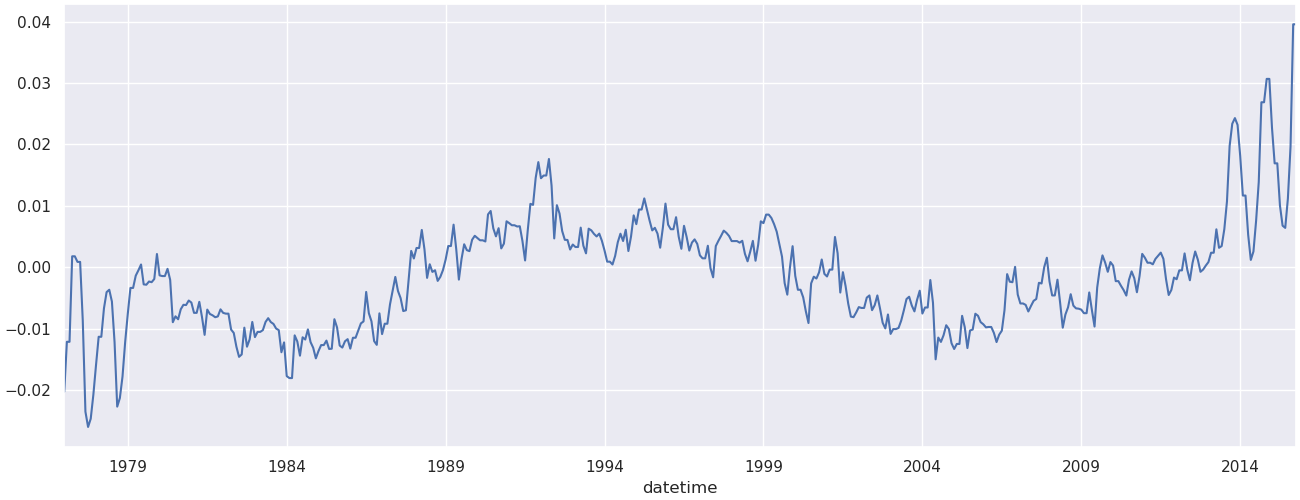

In [19]:
mg_highs = find_highs(data.elevation) - trend
fig, ax = plt.subplots(figsize=(13, 5), constrained_layout=True)
window = pd.Timedelta("365.25D") * 5
mg_highs.groupby(pd.Grouper(freq="MS")).mean().rolling(window=window, center=True).mean().plot(ax=ax)

<AxesSubplot:xlabel='datetime'>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
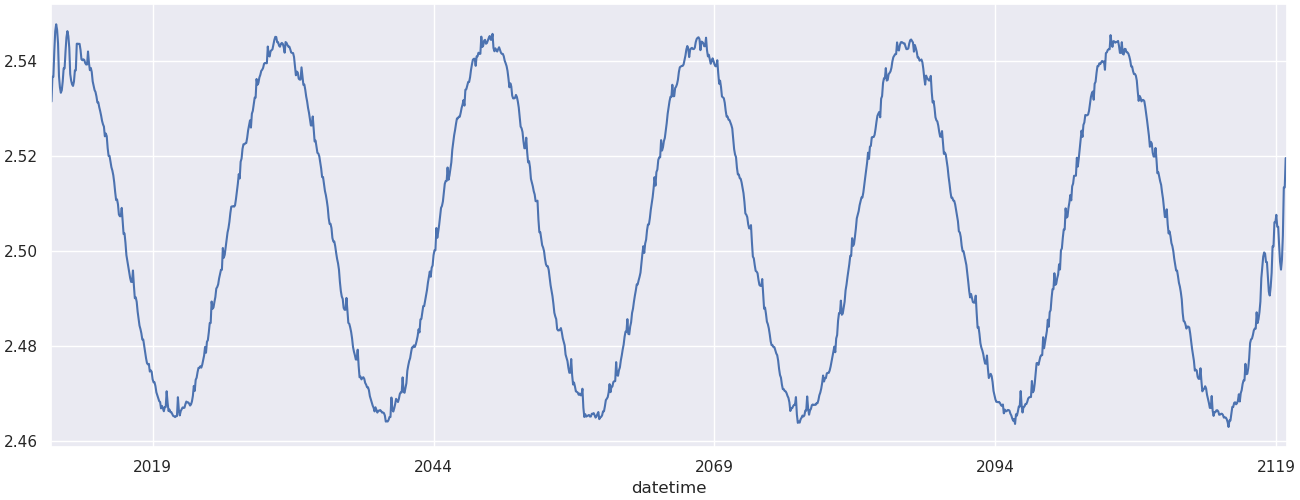

In [9]:
fig, ax = plt.subplots(figsize=(13, 5), constrained_layout=True)
window = pd.Timedelta("365.25D") * 5
ast_highs.groupby(pd.Grouper(freq="MS")).mean().rolling(window=window, center=True).mean().plot(ax=ax)

(84.0, 851.0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
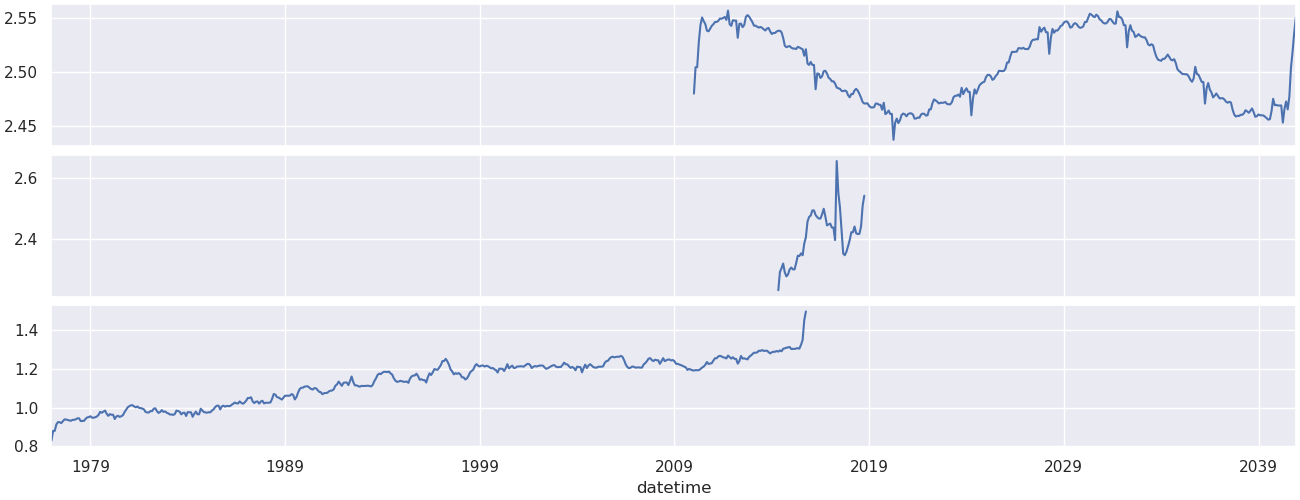

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 5), constrained_layout=True, nrows=3, sharex=True)

window = pd.Timedelta("365.25D")

ast_highs.groupby(pd.Grouper(freq="MS")).mean().rolling(window=window, center=True).mean().plot(ax=ax1)
sk_highs.groupby(pd.Grouper(freq="MS")).mean().rolling(window=window, center=True).mean().plot(ax=ax2)
mg_highs.groupby(pd.Grouper(freq="MS")).mean().rolling(window=window, center=True).mean().plot(ax=ax3)

ax3.set_xlim(pd.concat([ast_highs, sk_highs, mg_highs]).index.min(), pd.concat([ast_highs, sk_highs, mg_highs]).index.max())


<AxesSubplot:xlabel='datetime'>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
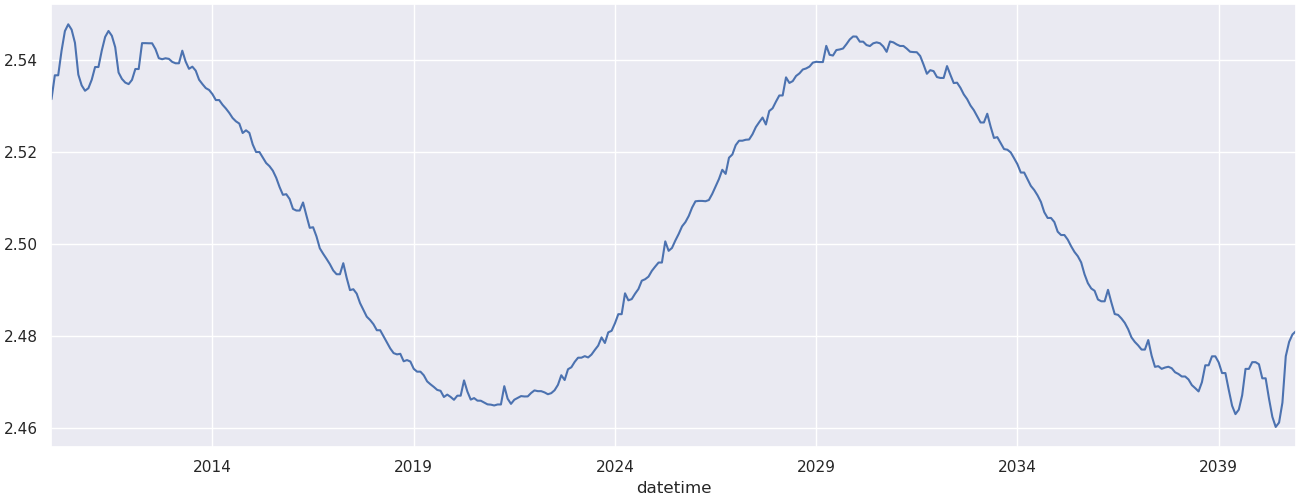

In [19]:
fig, ax = plt.subplots(figsize=(13, 5), constrained_layout=True)
tides.highs.groupby(pd.Grouper(freq="MS")).mean().rolling(window=pd.Timedelta("365.25D")*5, center=True).mean().plot(ax=ax)